In [178]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import shutil
import tarfile
from scipy import stats
from datetime import datetime
import re
from collections import defaultdict
from numpy import linalg as LA
import community
import community.community_louvain as community_louvain

# Set the seed for reproducibility
np.random.seed(42)

In [44]:
plt.rcParams['text.usetex'] = True
date_format = "%Y-%m-%d"

# Preprocessing

In [45]:
def copy_contents(src_directory, dst_directory):
    """
    Copy the contents of a source directory to a destination directory, preserving the folder structure.

    Args:
        src_directory (str): The source directory to copy from.
        dst_directory (str): The destination directory to copy to.

    Returns:
        list: A list of folder names that were copied.
    """
    
    # Ensure the source directory exists
    if not os.path.exists(src_directory):
        raise ValueError(f"Source directory '{src_directory}' does not exist.")
    
    folder_names = []

    # Walk through the source directory
    for dirpath, dirnames, filenames in os.walk(src_directory):
        # Save the folder names
        if dirpath != src_directory:  # Exclude the root directory itself
            folder_names.append(os.path.basename(dirpath))

        # Construct a destination path relative to the destination directory
        relative_path = os.path.relpath(dirpath, src_directory)
        destination_path = os.path.join(dst_directory, relative_path)

        # Create the destination directory
        os.makedirs(destination_path, exist_ok=True)

        # Copy each parquet file in the current directory to the destination directory
        for filename in filenames:
            if filename.endswith('.parquet') and filename != '.DS_Store':
                src_file = os.path.join(dirpath, filename)
                dst_file = os.path.join(destination_path, filename)
                shutil.copy2(src_file, dst_file)  # copy2 preserves metadata

    return folder_names

raw_data_path = 'SP500_2010/raw'
clean_data_path = 'SP500_2010/clean'

assets = copy_contents(raw_data_path, clean_data_path)

In [46]:
print(len(assets))

401


We have a total of 401 assets to manage, and to simplify access, let's create a function to retrieve them from the Parquet file effortlessly.

In [219]:
def get_asset(asset, date):
    """
    Get the file path for a specific asset and date.

    Args:
        asset (str): The asset name.
        date (str): The date in the format 'YYYY-MM-DD'.

    Returns:
        str: The file path for the specified asset and date.
    """
    
    asset_folder = f"{clean_data_path}/{asset}"
    path = f"{asset_folder}/{date}-{asset}-bbo_60seconds.parquet"
        
    return path

Let's illustrate with an example: retrieving the asset data for IBM on October 27th, 2010.

In [226]:
IBM_2010_10_27 = get_asset("IBM", "2010-10-27")
df = pd.read_parquet(IBM_2010_10_27)
df

,index,X.Open,X.High,X.Low,X.Close
0,2010-10-27 09:31:00-04:00,139.22,20.0,139.20,3.0
1,2010-10-27 09:32:00-04:00,139.21,21.0,139.30,4.0
2,2010-10-27 09:33:00-04:00,139.74,18.0,139.76,5.0
3,2010-10-27 09:34:00-04:00,140.07,22.0,139.90,1.0
4,2010-10-27 09:35:00-04:00,139.93,14.0,139.89,1.0
...,...,...,...,...,...
385,2010-10-27 15:56:00-04:00,141.41,28.0,141.39,6.0
386,2010-10-27 15:57:00-04:00,141.47,26.0,141.48,1.0
387,2010-10-27 15:58:00-04:00,141.48,67.0,141.48,6.0
388,2010-10-27 15:59:00-04:00,141.55,47.0,141.48,11.0


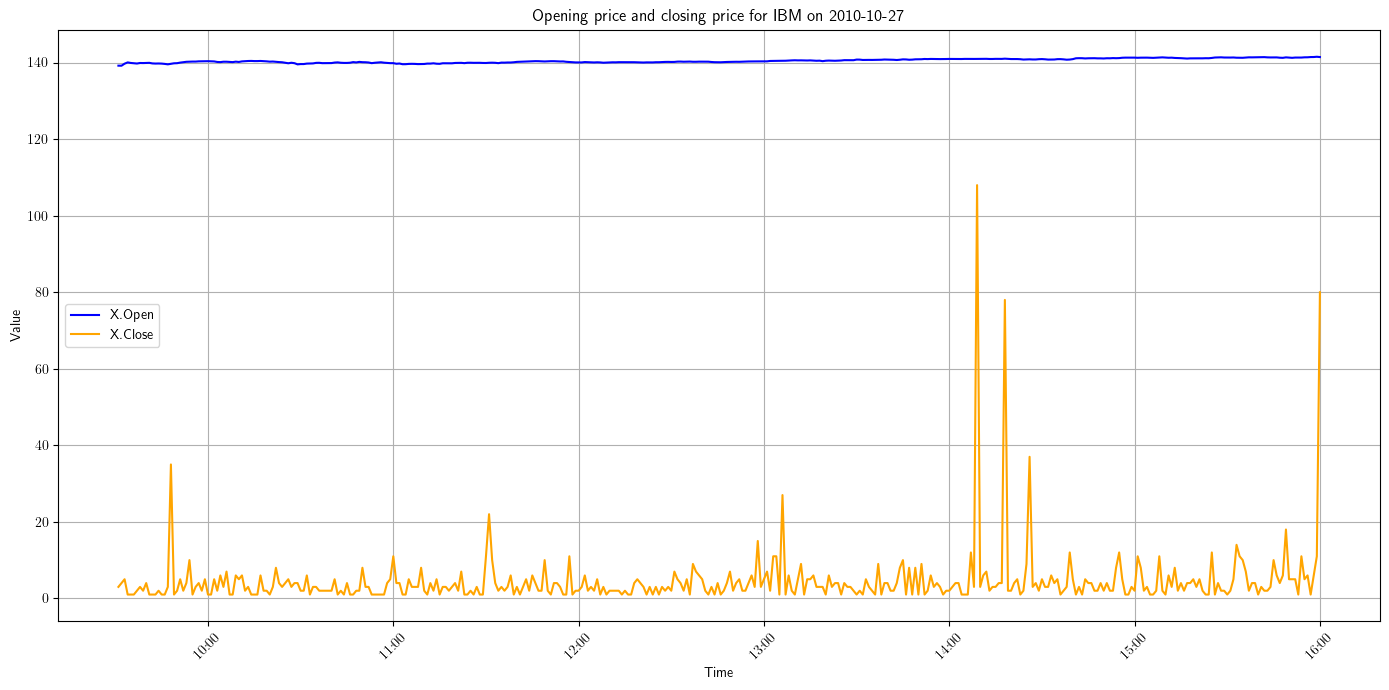

In [227]:
# Convert 'index' to datetime
df['index'] = pd.to_datetime(df['index'])

# Ensure that the plotted times match the original timezone's times without conversion
df['index'] = df['index'].dt.tz_localize(None)

# Set the converted 'index' as the DataFrame's index
df.set_index('index', inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['X.Open'], label='X.Open', color='blue')
plt.plot(df.index, df['X.Close'], label='X.Close', color='orange')

# Formatting the x-axis to show time only
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set ticks every hour

# Adding plot decorations
plt.title("Opening price and closing price for IBM on 2010-10-27")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout() 

plt.show()

We need to ensure that the data we work with includes dates common to all assets' files. In other words, we should only work with data files where all assets have data available for the same set of dates. This will help us identify and exclude assets that lack sufficient data, ensuring data availability consistency across assets.

In [49]:
def count_dates_for_assets(base_directory, assets):
    """
    Count the number of unique dates associated with each asset within a base directory.

    Args:
        base_directory (str): The base directory containing asset subdirectories.
        assets (list): A list of asset names.

    Returns:
        dict: A dictionary where keys are asset names and values are the count of unique dates.
    """

    date_counts = {}

    for asset in assets:
        asset_directory = os.path.join(base_directory, asset)
        dates = set()

        # Check if the asset directory exists
        if os.path.isdir(asset_directory):
            # Count unique dates for the asset
            for file in os.listdir(asset_directory):
                if file.endswith(".parquet"):
                    date = file[:10]  # Extract the date from the filename
                    dates.add(date)

        date_counts[asset] = len(dates)

    return date_counts

date_counts = count_dates_for_assets(clean_data_path, assets)

In [50]:
def compute_statistics(date_counts):
    """
    Compute statistics (mean, median, minimum, and maximum) for a dictionary of date counts.

    Args:
        date_counts (dict): A dictionary where keys are categories and values are counts.

    Returns:
        tuple: A tuple containing the mean, median, minimum, and maximum values.
    """

    # Convert the values of the date_counts dictionary to a NumPy array
    values = np.array(list(date_counts.values()))

    # Calculate mean, median, minimum, and maximum
    mean = np.mean(values)
    median = np.median(values)
    min_value = np.min(values)
    max_value = np.max(values)

    return mean, median, min_value, max_value

# Compute statistics
mean, median, min_value, max_value = compute_statistics(date_counts)

# Display the computed statistics
print(f"Mean number of dates: {mean}")
print(f"Median number of dates: {median}")
print(f"Minimum number of dates: {min_value}")
print(f"Maximum number of dates: {max_value}")

Mean number of dates: 245.15960099750623
Median number of dates: 251.0
Minimum number of dates: 12
Maximum number of dates: 252


Since the median stands at 251, we can establish a safe threshold of 250. Therefore, we will exclusively focus on assets for which daily data is available for more than 250 days.

In [51]:
def filter_assets_by_date_threshold(base_directory, assets, threshold):
    """
    Filter assets based on a date count threshold.

    Args:
        base_directory (str): The base directory containing asset subdirectories.
        assets (list): A list of asset names.
        threshold (int): The minimum date count required for an asset to be included.

    Returns:
        list: A list of asset names that meet the date count threshold.
    """

    # Count dates for each asset
    date_counts = count_dates_for_assets(base_directory, assets)

    # Filter assets based on the threshold
    filtered_assets = [asset for asset, count in date_counts.items() if count > threshold]

    return filtered_assets

# Defining the treshold
threshold = 250

# Filter assets based on the threshold and display the count
assets_above_threshold = filter_assets_by_date_threshold(clean_data_path, assets, threshold)
print(len(assets_above_threshold))

351


We've identified 50 assets with insufficient data, which we'll exclude, leaving us with 351 assets. Next, we need to filter out the days for which we lack data across all of the filtered assets.

In [11]:
def available_data_per_asset(clean_data_path, assets):
    """
    Find common dates among a list of assets based on available data.

    Args:
        clean_data_path (str): The path to the directory containing clean data.
        assets (list): A list of asset names.

    Returns:
        list: A list of common dates available for all specified assets.
    """
    
    dates_dict = defaultdict(set)

    # Iterate over each asset
    for asset in assets:
        asset_directory = os.path.join(clean_data_path, asset)

        # Check if the asset directory exists
        if os.path.isdir(asset_directory):
            # List all parquet files for the asset
            for file in os.listdir(asset_directory):
                if file.endswith(".parquet"):
                    # Extract the date from the file name
                    date = file[:10]
                    dates_dict[asset].add(date)

    # Find dates common to all assets
    common_dates = set.intersection(*dates_dict.values()) if dates_dict else set()

    return list(common_dates)

# Find common dates among filtered assets
common_dates = available_data_per_asset(clean_data_path, assets_above_threshold)

In [12]:
print(len(common_dates))

250


As a result, we will be working with a set of 351 assets spanning over 250 days, ensuring that all the necessary data is now available.

In [52]:
import pandas as pd

def process_bbo(asset, date):
    """
    Process Best Bid and Offer (BBO) data for a specific asset and date.

    Args:
        asset (str): The asset name.
        date (str): The date in the format 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: A DataFrame containing processed BBO data.
    """
    # Assuming get_asset function returns the file path
    bbo = get_asset(asset, date)
    
    # Read the BBO data into a DataFrame
    df = pd.read_parquet(bbo)

    # Ensure 'X.Open' is not NaN by filtering rows
    df_non_nan = df[df['X.Open'].notna()]

    # Convert 'index' column to datetime if not already
    df_non_nan['index'] = pd.to_datetime(df_non_nan['index'])
    
    # Filter for the first non-NaN 'X.Open' value after 10:00
    morning_row = df_non_nan[df_non_nan['index'].dt.time > pd.Timestamp("10:00:00").time()].head(1)
    
    # Filter for the last non-NaN 'X.Open' value before 15:30
    afternoon_row = df_non_nan[df_non_nan['index'].dt.time < pd.Timestamp("15:30:00").time()].tail(1)
    
    # Select the last non-NaN 'X.Open' value in the DataFrame
    last_row = df_non_nan.tail(1)
    
    # Combine the selected rows
    result_df = pd.concat([morning_row, afternoon_row, last_row])

    # Keep only 'index' and 'X.Open' columns
    result_df = result_df[['index', 'X.Open']]

    # Save the result DataFrame back to the same parquet file, replacing the original
    result_df.to_parquet(bbo, index=True)
    
    return result_df

In [53]:
for asset in assets_above_threshold:
    for date in common_dates:
        # Process BBO data for the current asset and date
        processed_data = process_bbo(asset, date)

In [54]:
IBM_2010_01_04 = get_asset("IBM", "2010-01-04")
df = pd.read_parquet(IBM_2010_01_04)
df.head()

,index,X.Open
30,2010-01-04 10:01:00-05:00,132.73
358,2010-01-04 15:29:00-05:00,132.46
389,2010-01-04 16:00:00-05:00,132.45


The algorithm has efficiently retained only the three required rows.

# Matrix of returns computation

We begin by defining a function that calculates returns between two time instants, t1 and t2. Afterward, we will construct a matrix representing returns between t1 and t2.

In [59]:
def calculate_returns(df, t1, t2, log):
    """
    Calculate returns based on opening prices at two specified moments.

    Args:
        df (pd.DataFrame): DataFrame containing BBO data.
        t1 (int): Index of the first moment.
        t2 (int): Index of the second moment.
        log (bool): If True, calculate logarithmic returns; if False, calculate simple returns.

    Returns:
        float: Calculated returns.
    """

    try:
        if df.shape[0] < 3:
            return 0

        # Get the 'X.Open' for the specified moments
        opening_price_t1 = df['X.Open'].iloc[t1]
        opening_price_t2 = df['X.Open'].iloc[t2]

        # Calculate the returns
        returns = (opening_price_t2 - opening_price_t1) / opening_price_t1

        if log:
            returns = np.log(opening_price_t2 / opening_price_t1)

        return returns
    except Exception as e:
        # If there's any other issue, return 0
        return 0

In [205]:
def create_returns_matrix(dates, assets, t1, t2, log):
    """
    Create a returns matrix based on specified dates, assets, and time intervals.

    Args:
        dates (list): List of dates for the matrix.
        assets (list): List of asset names.
        t1 (int): Index of the first moment.
        t2 (int): Index of the second moment.
        log (bool): If True, calculate logarithmic returns; if False, calculate simple returns.

    Returns:
        pd.DataFrame: DataFrame representing the returns matrix.
    """
    
    # Initialize the matrix as a DataFrame
    return_matrix = pd.DataFrame(index=dates, columns=assets)

    # Iterate over each date and asset
    for date in dates:
        for asset in assets:
            # Process the data for the given asset and date
            file_path = get_asset(asset, date)
            processed_data = pd.read_parquet(file_path)

            # Compute the returns
            returns = calculate_returns(processed_data, t1, t2, log)
            
            # Check if returns is a numeric value (not an error message)
            if isinstance(returns, (int, float, np.number)):
                return_matrix.at[date, asset] = returns
            else:
                return_matrix.at[date, asset] = np.nan  # Assign NaN for errors or non-numeric values

    return return_matrix

In [61]:
# Create a returns matrix for specified dates, assets, and time intervals (t1=0, t2=1) with simple returns
returns_matrix_t1_t2 = create_returns_matrix(common_dates, assets_above_threshold, t1=0, t2=1, log=False)

# Sort the returns matrix by index
returns_matrix_t1_t2.sort_index(inplace=True)

# Save the sorted returns matrix with normal (simple) returns as a Parquet file
returns_matrix_t1_t2.to_parquet('returns_matrix_t1_t2.parquet')

# Display the first few rows of the returns matrix with simple returns
returns_matrix_t1_t2.head()

/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1


,VZ,CNP,RCL,CAT,TFC,MHS,PM,TEL,PLL,MBF,...,HUM,HST,NVR,STT,TI,CCI,STZ,GLW,PKI,VNO
2010-01-04,-0.001502,-0.002749,-0.015314,0.006352,0.00774,0.00619,0.011868,0.006454,0.004923,0.0,...,0.018287,-0.000846,0.022175,0.014579,0.005777,-0.002022,0.007505,0.005131,0.001954,-0.00736
2010-01-05,0.013074,-0.009655,-0.016362,0.010769,0.004658,-0.014356,-0.007928,-0.00486,0.001093,0.0,...,0.005057,0.009251,0.022952,-0.001578,0.001913,-0.001003,-0.002502,-0.018546,0.017561,-0.003317
2010-01-06,-0.016049,-0.009053,-0.011751,0.000673,0.001527,-0.003926,0.003301,0.013693,0.001633,0.0,...,0.010086,-0.003292,0.013377,-0.016209,-0.001276,-0.00203,0.006927,-0.01576,0.017167,-0.017123
2010-01-07,0.001901,0.004926,-0.001182,0.014826,0.003072,0.009238,0.010244,-0.0116,0.006797,0.0,...,0.025991,0.037923,0.008736,0.00953,-0.001296,-0.00743,0.026316,0.01087,-0.021669,0.019155
2010-01-08,-0.001265,-0.004899,0.001946,0.006038,0.004608,0.017212,-0.004874,0.009282,0.008902,0.0,...,-0.006064,-0.002402,-0.009161,0.003552,-0.003911,0.007758,-0.00827,0.022154,0.006106,-0.005022


In [62]:
# Create a returns matrix for specified dates, assets, and time intervals (t1=0, t2=1) with log returns
log_returns_matrix_t1_t2 = create_returns_matrix(common_dates, assets_above_threshold, t1=0, t2=1, log=True)

# Sort the log returns matrix by index
log_returns_matrix_t1_t2.sort_index(inplace=True)

# Save the sorted log returns matrix as a Parquet file
log_returns_matrix_t1_t2.to_parquet('log_returns_matrix_t1_t2.parquet')

# Display the first few rows of the log returns matrix
log_returns_matrix_t1_t2.head()

/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  returns = np.log(opening_price_t2 / opening_price_t1)
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  returns = np.log(opening_price_t2 / opening_price_t1)
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:27: RuntimeWarning: divide by zero encountered in log
  returns = np.log(opening_price_t2 / opening

,VZ,CNP,RCL,CAT,TFC,MHS,PM,TEL,PLL,MBF,...,HUM,HST,NVR,STT,TI,CCI,STZ,GLW,PKI,VNO
2010-01-04,-0.001503,-0.002753,-0.015432,0.006332,0.00771,0.006171,0.011798,0.006433,0.004911,0.0,...,0.018122,-0.000846,0.021932,0.014473,0.00576,-0.002024,0.007477,0.005118,0.001952,-0.007387
2010-01-05,0.012989,-0.009702,-0.016498,0.010712,0.004648,-0.01446,-0.00796,-0.004872,0.001092,0.0,...,0.005044,0.009209,0.022692,-0.001579,0.001911,-0.001004,-0.002505,-0.018721,0.017409,-0.003323
2010-01-06,-0.01618,-0.009094,-0.01182,0.000672,0.001526,-0.003934,0.003296,0.0136,0.001632,0.0,...,0.010035,-0.003298,0.013288,-0.016342,-0.001277,-0.002032,0.006903,-0.015886,0.017022,-0.017272
2010-01-07,0.001899,0.004914,-0.001183,0.014717,0.003067,0.009195,0.010192,-0.011668,0.006774,0.0,...,0.025659,0.037221,0.008698,0.009485,-0.001297,-0.007458,0.025975,0.010811,-0.021907,0.018974
2010-01-08,-0.001265,-0.004911,0.001944,0.00602,0.004598,0.017065,-0.004886,0.009239,0.008863,0.0,...,-0.006083,-0.002405,-0.009203,0.003546,-0.003919,0.007728,-0.008304,0.021912,0.006088,-0.005035


# Clustering

We apply Louvain clustering and modify the code we've seen in class. While the code in class was used for clustering assets, we now transpose the matrix to create clusters based on time.

In [63]:
def compute_C_minus_C0(lambdas, v, lambda_plus, removeMarketMode=True):
    """
    Compute the cleaned correlation matrix C - C0.

    Args:
        lambdas (numpy.ndarray): Eigenvalues of the correlation matrix.
        v (numpy.ndarray): Eigenvectors of the correlation matrix.
        lambda_plus (float): Threshold for eigenvalues.
        removeMarketMode (bool): Flag to remove the market mode.

    Returns:
        numpy.ndarray: Cleaned correlation matrix.
    """
    N = len(lambdas)
    C_clean = np.zeros((N, N))
    
    # Sort eigenvalues and eigenvectors in ascending order
    order = np.argsort(lambdas)
    lambdas, v = lambdas[order], v[:, order]
    
    v_m = np.matrix(v)

    for i in range(1 * removeMarketMode, N):                            
        if lambdas[i] > lambda_plus: 
            C_clean = C_clean + lambdas[i] * np.dot(v_m[:, i], v_m[:, i].T)  
    return C_clean

def LouvainCorrelationClustering(R, time_window, n):
    """
    Perform Louvain community detection on correlation matrix of returns data.

    Args:
        R (pd.DataFrame): DataFrame of returns.
        time_window (int): Number of days to consider.
        n (int): Number of assets to sample.

    Returns:
        pd.DataFrame: DataFrame with communities assigned to assets.
    """
    
    # Selecting the first time_window days and preserving the original dates
    original_dates = R.index[:time_window]
    R = R.iloc[:time_window]

    # Sampling n random assets
    R = R.sample(n=n, axis=1)

    # Transposing the matrix since we are creating day clusters
    R = R.T

    N = R.shape[1]
    T = R.shape[0]

    q = N * 1. / T
    lambda_plus = (1. + np.sqrt(q)) ** 2

    # Compute correlation matrix from DataFrame
    C = R.corr().values
    lambdas, v = LA.eigh(C)
            
    C_s = compute_C_minus_C0(lambdas, v, lambda_plus)
    
    # Convert the cleaned matrix back to DataFrame for graph creation
    mygraph = nx.from_numpy_array(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)

    # Map partition results back to the original dates
    partition_with_dates = {original_dates[i]: cluster for i, cluster in partition.items()}

    # Create DataFrame from the partition dictionary with dates
    df = pd.DataFrame.from_dict(partition_with_dates, orient="index", columns=['Community'])

    return df

In [64]:
# Calculate the number of assets that meet the date count threshold
N = len(assets_above_threshold)

# Calculate the number of common dates available for all specified assets
T = len(common_dates)

We establish a time window for the rolling calibration process and specify 'n,' which represents the number of sampled assets.

### Experiences A: using regular returns

Experience A.1: time_window = T (all days), n = N (all assets), using regular returns.

In [65]:
num_iterations = 100  # Number of iterations for Louvain clustering
time_window = T  # Time window (equal to the number of common dates)
number_of_sampled_assets = N  # Number of assets to sample

cluster_A_1_counts = []  # List to store the number of clusters in each iteration

# Perform Louvain clustering multiple times
for _ in range(num_iterations):
    clusters = LouvainCorrelationClustering(returns_matrix_t1_t2, time_window, number_of_sampled_assets)
    num_clusters = len(clusters['Community'].unique())
    cluster_A_1_counts.append(num_clusters)

# Calculate mean and standard deviation of the cluster counts
mean_clusters = np.mean(cluster_A_1_counts)
std_clusters = np.std(cluster_A_1_counts, ddof=1)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(cluster_A_1_counts) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_clusters, std_clusters/np.sqrt(len(cluster_A_1_counts)))

# Display the results
print(f"Mean number of clusters: {mean_clusters}")
print(f"Standard deviation: {std_clusters}")
print(f"95% Confidence interval: {confidence_interval}")

Mean number of clusters: 4.46
Standard deviation: 0.5932277740625365
95% Confidence interval: (4.342290739459935, 4.577709260540065)


Experience A.2: time_window = N/3, n = N (all assets), using regular returns.

In [66]:
num_iterations = 100  # Number of iterations for Louvain clustering
time_window = int(N / 3)  # Time window (one-third of the number of assets)
number_of_sampled_assets = N  # Number of assets to sample

cluster_A_2_counts = []  # List to store the number of clusters in each iteration

# Perform Louvain clustering multiple times
for _ in range(num_iterations):
    clusters = LouvainCorrelationClustering(returns_matrix_t1_t2, time_window, number_of_sampled_assets)
    num_clusters = len(clusters['Community'].unique())
    cluster_A_2_counts.append(num_clusters)

# Calculate mean and standard deviation of the cluster counts
mean_clusters = np.mean(cluster_A_2_counts)
std_clusters = np.std(cluster_A_2_counts, ddof=1)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(cluster_A_2_counts) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_clusters, std_clusters/np.sqrt(len(cluster_A_2_counts)))

# Display the results
print(f"Mean number of clusters: {mean_clusters}")
print(f"Standard deviation: {std_clusters}")
print(f"95% Confidence interval: {confidence_interval}")

Mean number of clusters: 4.95
Standard deviation: 0.5388914922357194
95% Confidence interval: (4.843072236608208, 5.056927763391792)


Experience A.3: time_window = N/4, n = N (all assets), using regular returns.

In [67]:
num_iterations = 100  # Number of iterations for Louvain clustering
time_window = int(N / 4)  # Time window (one-fourth of the number of assets)
number_of_sampled_assets = N  # Number of assets to sample

cluster_A_3_counts = []  # List to store the number of clusters in each iteration

# Perform Louvain clustering multiple times
for _ in range(num_iterations):
    clusters = LouvainCorrelationClustering(returns_matrix_t1_t2, time_window, number_of_sampled_assets)
    num_clusters = len(clusters['Community'].unique())
    cluster_A_3_counts.append(num_clusters)

# Calculate mean and standard deviation of the cluster counts
mean_clusters = np.mean(cluster_A_3_counts)
std_clusters = np.std(cluster_A_3_counts, ddof=1)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(cluster_A_3_counts) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_clusters, std_clusters/np.sqrt(len(cluster_A_3_counts)))

# Display the results
print(f"Mean number of clusters: {mean_clusters}")
print(f"Standard deviation: {std_clusters}")
print(f"95% Confidence interval: {confidence_interval}")

Mean number of clusters: 5.99
Standard deviation: 0.6434597143880914
95% Confidence interval: (5.862323632709821, 6.117676367290179)


### Experience B: using log returns

Experience B.1: time_window = T (all days), n = N (all assets), using log returns.

In [68]:
num_iterations = 100  # Number of iterations for Louvain clustering
time_window = T  # Time window (equal to the number of common dates)
number_of_sampled_assets = N  # Number of assets to sample

cluster_B_1_counts = []  # List to store the number of clusters in each iteration

# Perform Louvain clustering multiple times on log returns matrix
for _ in range(num_iterations):
    clusters = LouvainCorrelationClustering(log_returns_matrix_t1_t2, time_window, number_of_sampled_assets)
    num_clusters = len(clusters['Community'].unique())
    cluster_B_1_counts.append(num_clusters)

# Calculate mean and standard deviation of the cluster counts
mean_clusters = np.mean(cluster_B_1_counts)
std_clusters = np.std(cluster_B_1_counts, ddof=1)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(cluster_B_1_counts) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_clusters, std_clusters/np.sqrt(len(cluster_B_1_counts)))

# Display the results
print(f"Mean number of clusters: {mean_clusters}")
print(f"Standard deviation: {std_clusters}")
print(f"95% Confidence interval: {confidence_interval}")


Mean number of clusters: 4.58
Standard deviation: 0.6843119378491277
95% Confidence interval: (4.444217665280001, 4.715782334719999)


Experience B.2: time_window = N/3, n = N (all assets), using log returns.

In [69]:
num_iterations = 100  # Number of iterations for Louvain clustering
time_window = int(N / 3)  # Time window (one-third of the number of assets)
number_of_sampled_assets = N  # Number of assets to sample

clusters_B_2_counts = []  # List to store the number of clusters in each iteration

# Perform Louvain clustering multiple times on log returns matrix
for _ in range(num_iterations):
    clusters = LouvainCorrelationClustering(log_returns_matrix_t1_t2, time_window, number_of_sampled_assets)
    num_clusters = len(clusters['Community'].unique())
    clusters_B_2_counts.append(num_clusters)

# Calculate mean and standard deviation of the cluster counts
mean_clusters = np.mean(clusters_B_2_counts)
std_clusters = np.std(clusters_B_2_counts, ddof=1)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(clusters_B_2_counts) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_clusters, std_clusters/np.sqrt(len(clusters_B_2_counts)))

# Display the results
print(f"Mean number of clusters: {mean_clusters}")
print(f"Standard deviation: {std_clusters}")
print(f"95% Confidence interval: {confidence_interval}")

Mean number of clusters: 4.98
Standard deviation: 0.5120763831912405
95% Confidence interval: (4.878392936000469, 5.081607063999532)


Experience B.3: time_window = N/4, n = N (all assets), using log returns.

In [70]:
num_iterations = 100  # Number of iterations for Louvain clustering
time_window = int(N / 4)  # Time window (one-fourth of the number of assets)
number_of_sampled_assets = N  # Number of assets to sample

clusters_B_3_counts = []  # List to store the number of clusters in each iteration

# Perform Louvain clustering multiple times on log returns matrix
for _ in range(num_iterations):
    clusters = LouvainCorrelationClustering(log_returns_matrix_t1_t2, time_window, number_of_sampled_assets)
    num_clusters = len(clusters['Community'].unique())
    clusters_B_3_counts.append(num_clusters)

# Calculate mean and standard deviation of the cluster counts
mean_clusters = np.mean(clusters_B_3_counts)
std_clusters = np.std(clusters_B_3_counts, ddof=1)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(clusters_B_3_counts) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_clusters, std_clusters/np.sqrt(len(clusters_B_3_counts)))

# Display the results
print(f"Mean number of clusters: {mean_clusters}")
print(f"Standard deviation: {std_clusters}")
print(f"95% Confidence interval: {confidence_interval}")

Mean number of clusters: 6.02
Standard deviation: 0.5314360191257668
95% Confidence interval: (5.914551564220836, 6.125448435779163)


In the end, we observed relatively stable results across all the experiences, with a mean of numbers of clusters relatively higher when using log returns, with a slightely lower standard deviation. Since we expect 5-6 clusters, we opted for regular returns with all the assets. To create clusters during each iteration of the rolling calibration, we set the time window to N/4 within the rolling calibration, aligning with experience A.3. In this experiment, the low standard deviation suggests robustness and holds the promise of producing stable results.

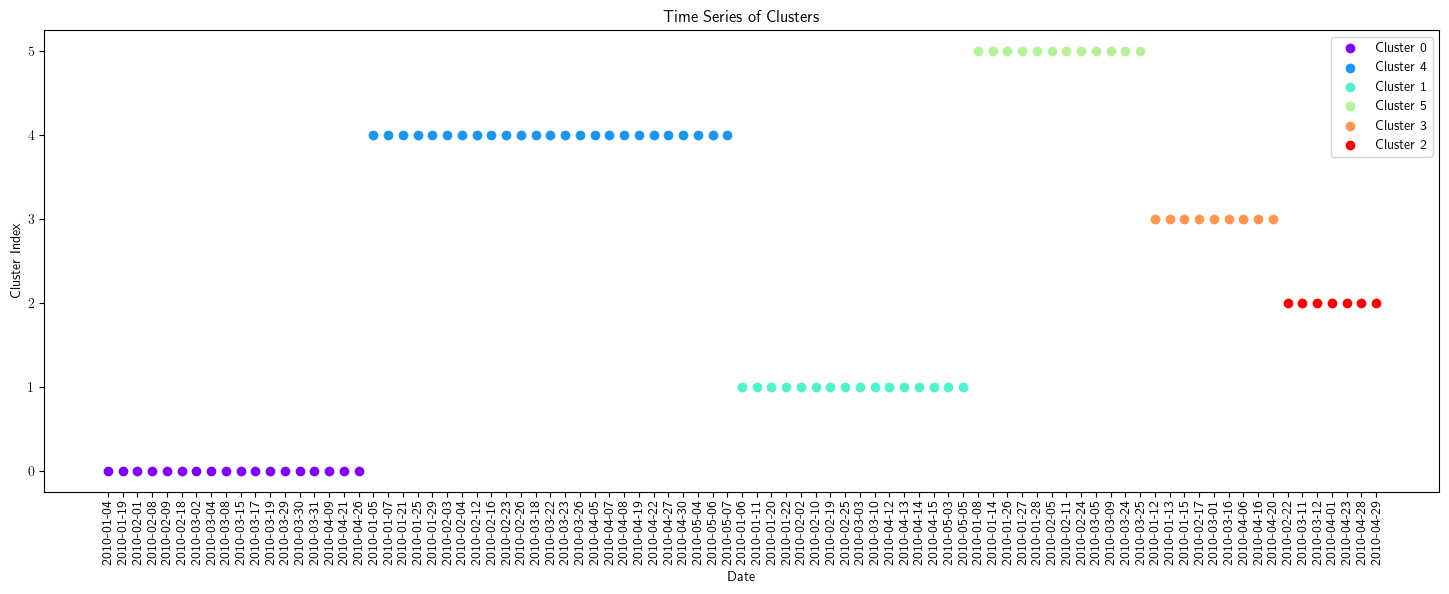

In [75]:
time_window = int(N / 4)  # Time window (one-fourth of the number of assets)
number_of_sampled_assets = N  # Number of assets to sample

# Perform Louvain clustering on returns matrix
clusters_A_4 = LouvainCorrelationClustering(returns_matrix_t1_t2, time_window, number_of_sampled_assets)

# Sort the clusters based on index (date)
clusters_A_4_sorted = clusters_A_4.sort_index()

# Map each unique cluster to a color using a colormap
unique_clusters = clusters_A_4_sorted['Community'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))
color_map = dict(zip(unique_clusters, colors))

# Plotting
plt.figure(figsize=(18, 6))
for cluster in unique_clusters:
    clustered_data = clusters_A_4_sorted[clusters_A_4_sorted['Community'] == cluster]
    plt.scatter(clustered_data.index, clustered_data['Community'], color=color_map[cluster], label=f'Cluster {cluster}')

plt.xlabel('Date')
plt.ylabel('Cluster Index')
plt.title('Time Series of Clusters')
plt.xticks(rotation=90)  # Rotates x-axis labels to vertical
plt.legend()
plt.grid(False)
plt.show()

# Trading Strategy

Having chosen simple returns for improved clustering outcomes, we can proceed to construct our daily return matrix between t2 (15:30) and t3 (16:00) using these simple returns.

In [76]:
# Create a returns matrix for time periods t2 to t3 (normal returns)
returns_matrix_t2_t3 = create_returns_matrix(common_dates, assets_above_threshold, t1=1, t2=2, log=False)

# Sort the returns matrix by index (date)
returns_matrix_t2_t3.sort_index(inplace=True)

# Save the returns matrix to a Parquet file
returns_matrix_t2_t3.to_parquet('returns_matrix_t2_t3.parquet')

/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: invalid value encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: invalid value encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: invalid value encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: invalid value encountered in scalar divide
  returns = (opening_price_t2 - opening_price_t1) / opening_price_t1
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/1196006442.py:24: RuntimeWarning: invalid value encountered in scalar divide
  returns = (o

In [168]:
def calculate_mean_difference(returns_matrix_t2_t3, clusters):
    # Get the cluster of the final day
    final_day_cluster = clusters.iloc[-1]['Community']

    # Extract all days with the same cluster as the final day
    selected_days = clusters[clusters['Community'] == final_day_cluster].index

    # Filter the returns matrix to include only the selected days
    selected_returns = returns_matrix_t2_t3.loc[selected_days]

    # Initialize lists to store results for each asset
    assets = []
    expected_returns = []
    std_devs = []
    num_days_same_cluster = len(selected_returns)

    # Iterate over each asset
    for asset in returns_matrix_t2_t3.columns:
        # Calculate the expected return for the period t2 to t3 for each asset
        expected_return = selected_returns.loc[:, asset].mean()

        # Calculate the standard deviation for the period t2 to t3 for each asset
        std_dev = selected_returns.loc[:, asset].std()

        # Calculate the t-statistic for each asset
        t_statistic = (expected_return * np.sqrt(num_days_same_cluster)) / std_dev

        # Append results to lists
        assets.append(asset)
        expected_returns.append(expected_return)
        std_devs.append(std_dev)

    # Create a DataFrame to display the results
    t_statistic_df = pd.DataFrame({
        'Asset': assets,
        'Expected Return': expected_returns,
        'Std Deviation': std_devs,
        'T-Statistic': (np.array(expected_returns) * np.sqrt(num_days_same_cluster)) / np.array(std_devs)
    })

    # Rank the assets based on the t-statistic
    t_statistic_df['Rank'] = t_statistic_df['T-Statistic'].rank(ascending=False)

    # Select the top 5 for long positions based on T-Statistic
    top_long = t_statistic_df.nlargest(5, 'T-Statistic')
    top_long_assets = top_long['Asset']

    # Select the bottom 5 for short positions based on T-Statistic
    bottom_short = t_statistic_df.nsmallest(5, 'T-Statistic')
    bottom_short_assets = bottom_short['Asset']

    # Get the row corresponding to the final (current) day's returns
    day_T_returns = returns_matrix_t2_t3.iloc[-1]

    # Compute the difference in the mean of top5 assets and the mean of bottom5 assets
    daily_returns = day_T_returns[top_long_assets].mean() - day_T_returns[bottom_short_assets].mean()

    return daily_returns

In [167]:
time_window = int(N / 4)  # Time window (one-fourth of the number of assets)

# Initialize a list to hold daily returns and a list for the dates
daily_portfolio_returns = []
dates = []

# Iterate over the DataFrame with a rolling window
for start in range(0, T - time_window + 1):
    # Define the end of the window
    end = start + time_window

    # Slice the DataFrames to get the window for t1 to t2 and t2 to t3 returns
    returns_matrix_t1_t2_filtered = returns_matrix_t1_t2.iloc[start:end]
    returns_matrix_t2_t3_filtered = returns_matrix_t2_t3.iloc[start:end]

    # Get the current day's date
    date = returns_matrix_t2_t3_filtered.iloc[-1].name

    # Perform Louvain clustering on the sliced DataFrame for t1 to t2 returns
    clusters = LouvainCorrelationClustering(returns_matrix_t1_t2_filtered, time_window, number_of_sampled_assets)

    # Calculate the mean difference between top long and bottom short positions for t2 to t3 returns
    daily_return = calculate_mean_difference(returns_matrix_t2_t3_filtered, clusters)

    # Append the daily returns and the date to their respective lists
    daily_portfolio_returns.append(daily_return)
    dates.append(date)

# Convert list of returns and dates into DataFrame with 'daily_return' column and dates as index
daily_portfolio_returns_df = pd.DataFrame(daily_portfolio_returns, index=dates, columns=['daily_return'])

# Ensure the index name is 'date'
daily_portfolio_returns_df.index.name = 'date'

/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/3771624267.py:26: RuntimeWarning: invalid value encountered in scalar divide
  t_statistic = (expected_return * np.sqrt(num_days_same_cluster)) / std_dev
/var/folders/ly/08sscj_54fs44ft_r9s2lmvr0000gn/T/ipykernel_67438/3771624267.py:38: RuntimeWarning: invalid value encountered in divide
  'T-Statistic': (np.array(expected_returns) * np.sqrt(num_days_same_cluster)) / np.array(std_devs)


In [169]:
daily_portfolio_returns_df.to_csv("portfolio_returns.csv")

# Benchmark Strategy

We establish a benchmark strategy to compare and evaluate our own strategy effectively.

In [170]:
def calculate_mean_difference_benchmark(returns_matrix_t2_t3):
    # Initialize lists to store results for each asset
    assets = []
    expected_returns = []
    std_devs = []
    num_days = len(returns_matrix_t2_t3)

    # Iterate over each asset
    for asset in returns_matrix_t2_t3.columns:
        # Calculate the expected return for the period t2 to t3 for each asset
        expected_return = returns_matrix_t2_t3[asset].mean()

        # Calculate the standard deviation for the period t2 to t3 for each asset
        std_dev = returns_matrix_t2_t3[asset].std()

        # Append results to lists
        assets.append(asset)
        expected_returns.append(expected_return)
        std_devs.append(std_dev)

    # Create a DataFrame to display the results
    t_statistic_df = pd.DataFrame({
        'Asset': assets,
        'Expected Return': expected_returns,
        'Std Deviation': std_devs,
        'T-Statistic': (np.array(expected_returns) * np.sqrt(num_days)) / np.array(std_devs)
    })

    # Rank the assets based on the t-statistic
    t_statistic_df['Rank'] = t_statistic_df['T-Statistic'].rank(ascending=False)
    
    # Select the top 5 for long positions based on T-Statistic
    top_long = t_statistic_df.nlargest(5, 'T-Statistic')
    top_long_assets = top_long['Asset']

    # Select the bottom 5 for short positions based on T-Statistic
    bottom_short = t_statistic_df.nsmallest(5, 'T-Statistic')
    bottom_short_assets = bottom_short['Asset']

    # Get the row corresponding to the final (current) day's returns
    day_T_returns = returns_matrix_t2_t3.iloc[-1]

    # Compute the difference in the mean of top5 assets and the mean of bottom5 assets
    daily_returns = day_T_returns[top_long_assets].mean() - day_T_returns[bottom_short_assets].mean()

    return daily_returns

In [171]:
time_window = int(N / 4)  # Time window (one-fourth of the number of assets)
daily_benchmark_returns = []
dates = []

# Iterate over the DataFrame with a rolling window
for start in range(0, T - time_window + 1):
    # Define the end of the window
    end = start + time_window

    # Slice the DataFrames to get the window for t2 to t3 returns
    returns_matrix_t2_t3_filtered = returns_matrix_t2_t3.iloc[start:end]

    # Get the current day's date
    date = returns_matrix_t2_t3_filtered.iloc[-1].name

    # Calculate the mean difference (or any specific calculation for benchmark) for t2 to t3 returns
    daily_return = calculate_mean_difference_benchmark(returns_matrix_t2_t3_filtered)

    # Append the daily returns and the date to their respective lists
    daily_benchmark_returns.append(daily_return)
    dates.append(date)

# Convert list of returns and dates into DataFrame with 'daily_return' column and dates as index
daily_benchmark_returns_df = pd.DataFrame(daily_benchmark_returns, index=dates, columns=['daily_return'])

# Ensure the index name is 'date'
daily_benchmark_returns_df.index.name = 'date'

In [172]:
daily_benchmark_returns_df.to_csv("benchmark_returns.csv")

# Strategy Evaluation

## Daily Returns

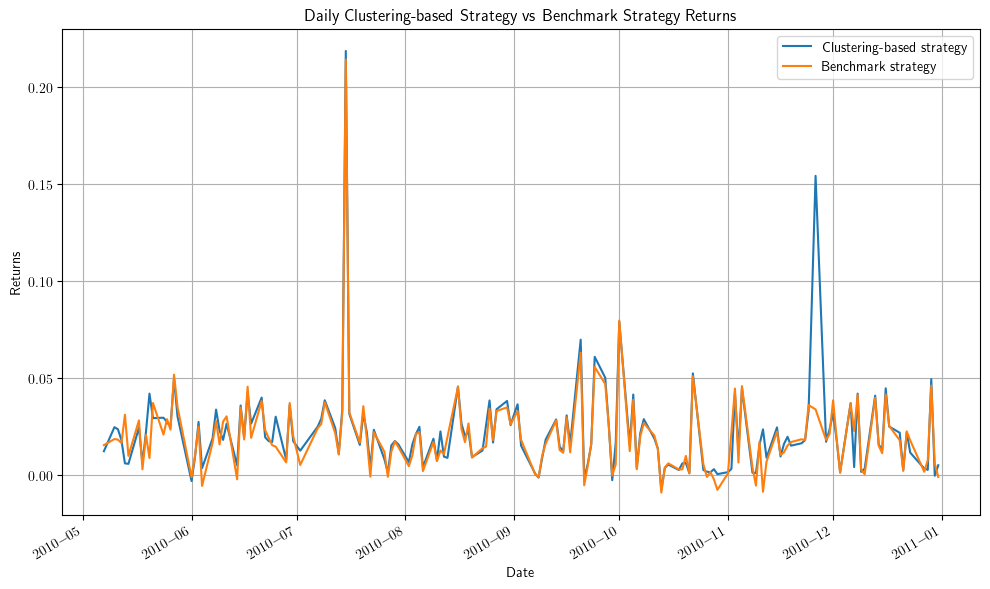

In [179]:
# Ensure the index is a datetime index
daily_portfolio_returns_df.index = pd.to_datetime(daily_portfolio_returns_df.index)
daily_benchmark_returns_df.index = pd.to_datetime(daily_benchmark_returns_df.index)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_portfolio_returns_df.index, daily_portfolio_returns_df['daily_return'], label='Clustering-based strategy')
plt.plot(daily_benchmark_returns_df.index, daily_benchmark_returns_df['daily_return'], label='Benchmark strategy')
plt.title('Daily Clustering-based Strategy vs Benchmark Strategy Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()

# Set the locator
locator = mdates.MonthLocator()  # Locate months
plt.gca().xaxis.set_major_locator(locator)

# Set the formatter for the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Autoformat the date labels to avoid overlap
plt.gcf().autofmt_xdate()

plt.grid(True)
plt.tight_layout()  # Adjust subplot parameters to give specified padding

# Show the plot
plt.show()

## Mean Daily Returns and Volatility

In [180]:
# Calculate mean daily returns for portfolio and benchmark
mean_daily_return_portfolio = daily_portfolio_returns_df['daily_return'].mean()
mean_daily_return_benchmark = daily_benchmark_returns_df['daily_return'].mean()

# Calculate volatility (standard deviation) of daily returns for portfolio and benchmark
volatility_clustering = daily_portfolio_returns_df['daily_return'].std()
volatility_benchmark = daily_benchmark_returns_df['daily_return'].std()

# Print the results
print(f"Clustering-based Strategy Mean Daily Return: {mean_daily_return_portfolio}")
print(f"Benchmark Strategy Mean Daily Return: {mean_daily_return_benchmark}")
print(f"Clustering-based Volatility: {volatility_clustering}")
print(f"Benchmark Volatility: {volatility_benchmark}")


Clustering-based Strategy Mean Daily Return: 0.02165897989284633
Benchmark Strategy Mean Daily Return: 0.019881926787592718
Clustering-based Volatility: 0.02392164262948273
Benchmark Volatility: 0.021441823963656778


In [181]:
# Extract the daily returns for both strategies
returns_clustering = daily_portfolio_returns_df['daily_return']
returns_benchmark = daily_benchmark_returns_df['daily_return']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(returns_clustering, returns_benchmark, alternative='greater')

# Print the t-statistic and the p-value
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Common choice for significance level
if p_value < alpha:
    print("We reject the null hypothesis. There is evidence that the mean daily return of the clustering-based strategy is significantly higher than the benchmark.")
else:
    print("There is not enough evidence to conclude that the mean daily return of the clustering-based strategy is significantly higher than the benchmark.")


T-Statistic: 0.7084075072274324
P-Value: 0.23959922687030283
There is not enough evidence to conclude that the mean daily return of the clustering-based strategy is significantly higher than the benchmark.


## Cumulative Returns

In [182]:
# Calculate cumulative returns for the portfolio
daily_portfolio_returns_df['cumulative_returns'] = (1 + daily_portfolio_returns_df['daily_return']).cumprod() - 1

# Calculate cumulative returns for the benchmark
daily_benchmark_returns_df['cumulative_returns'] = (1 + daily_benchmark_returns_df['daily_return']).cumprod() - 1

# To view the final cumulative return for the entire period:
final_cumulative_return_portfolio = daily_portfolio_returns_df['cumulative_returns'].iloc[-1]
final_cumulative_return_benchmark = daily_benchmark_returns_df['cumulative_returns'].iloc[-1]

print(f"Final Cumulative Return for Clustering-based strategy: {final_cumulative_return_portfolio * 100}%")
print(f"Final Cumulative Return for Benchmark strategy: {final_cumulative_return_benchmark * 100}%")

Final Cumulative Return for Clustering-based strategy: 3121.067008736634%
Final Cumulative Return for Benchmark strategy: 2340.338341171785%


## Sharpe Ratio

In [186]:
# Risk-free rate data
risk_free_rate_us_2010 = {
    "January": 3.76,
    "February": 3.79,
    "March": 3.68,
    "April": 3.86,
    "May": 3.25,
    "June": 3.21,
    "July": 3.00,
    "August": 2.58,
    "September": 2.77,
    "October": 2.52,
    "November": 2.90,
    "December": 3.47
}

# Convert annual rates to daily (as decimals)
for month in risk_free_rate_us_2010:
    annual_rate = risk_free_rate_us_2010[month]
    daily_rate = (1 + annual_rate / 100) ** (1/365) - 1
    risk_free_rate_us_2010[month] = daily_rate

# First, convert the index to datetime
daily_portfolio_returns_df.index = pd.to_datetime(daily_portfolio_returns_df.index)
daily_benchmark_returns_df.index = pd.to_datetime(daily_benchmark_returns_df.index)

# Map each day to its month name
daily_portfolio_returns_df['month'] = daily_portfolio_returns_df.index.month_name()
daily_benchmark_returns_df['month'] = daily_benchmark_returns_df.index.month_name()

# Map each month to its daily risk-free rate
daily_portfolio_returns_df['daily_risk_free_rate'] = daily_portfolio_returns_df['month'].map(risk_free_rate_us_2010)
daily_benchmark_returns_df['daily_risk_free_rate'] = daily_benchmark_returns_df['month'].map(risk_free_rate_us_2010)

# Calculate the adjusted daily returns
daily_portfolio_returns_df['adjusted_daily_return'] = daily_portfolio_returns_df['daily_return'] - daily_portfolio_returns_df['daily_risk_free_rate']
daily_benchmark_returns_df['adjusted_daily_return'] = daily_benchmark_returns_df['daily_return'] - daily_benchmark_returns_df['daily_risk_free_rate']

In [187]:
# Calculate the mean of the adjusted daily returns for both the portfolio and the benchmark
mean_adjusted_return_portfolio = daily_portfolio_returns_df['adjusted_daily_return'].mean()
mean_adjusted_return_benchmark = daily_benchmark_returns_df['adjusted_daily_return'].mean()

# Calculate the standard deviation (volatility) of the adjusted daily returns
std_dev_adjusted_portfolio = daily_portfolio_returns_df['adjusted_daily_return'].std()
std_dev_adjusted_benchmark = daily_benchmark_returns_df['adjusted_daily_return'].std()

# Compute the Sharpe Ratios
sharpe_ratio_portfolio = mean_adjusted_return_portfolio / std_dev_adjusted_portfolio
sharpe_ratio_benchmark = mean_adjusted_return_benchmark / std_dev_adjusted_benchmark

# Print the Sharpe Ratios
print(f"Clustering-based Portfolio Sharpe Ratio: {sharpe_ratio_portfolio}")
print(f"Benchmark Sharpe Ratio: {sharpe_ratio_benchmark}")

Clustering-based Portfolio Sharpe Ratio: 0.9020901312666585
Benchmark Sharpe Ratio: 0.923555058862741
